In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
import threading
import os
import cPickle as pickle
import logging
import pprint
import glob
import collections
import struct
import json
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)


In [4]:
logging.info('abc')

08/19/2017 07:41:13 AM INFO: abc


In [5]:
class GeneratorRunner(object):
    "Custom runner that that runs an generator in a thread and enqueues the outputs."

    def __init__(self, generator, placeholders, enqueue_op, close_op):
        self._generator = generator
        self._placeholders = placeholders
        self._enqueue_op = enqueue_op
        self._close_op = close_op

    def _run(self, sess, coord):
        try:
            while not coord.should_stop():
                try:
                    values = next(self._generator)

                    assert len(values) == len(self._placeholders), \
                        'generator values and placeholders must have the same length'

                    feed_dict = {placeholder: value \
                        for placeholder, value in zip(self._placeholders, values)}
                    sess.run(self._enqueue_op, feed_dict=feed_dict)
                except (StopIteration, tf.errors.OutOfRangeError, tf.errors.DeadlineExceededError, tf.errors.CancelledError) as e:
                    logging.warning ("%s %s %s", self.__class__.__name__, "exception:", str(type(e)))
                    try:
                        sess.run(self._close_op)
                    except Exception:
                        pass
                    return
        except Exception as ex:
            if coord:
                logging.info ("%s %s %s %s", self.__class__.__name__, "request stop from", self._run.__name__, str(ex))
                coord.request_stop(ex)
                pass
            else: 
                raise

    def create_threads(self, sess, coord=None, daemon=False, start=False):
        "Called by `start_queue_runners`."

        thread = threading.Thread(
            target=self._run,
            args=(sess, coord))

        if coord:
            coord.register_thread(thread)

        if daemon:
            thread.daemon = True

        if start:
            thread.start()

        return [thread]

def read_batch_generator(
        generator, dtypes, shapes, batch_size,
        queue_capacity=10000,
        allow_smaller_final_batch=False):
    "Reads values from an generator, queues, and batches."

    assert len(dtypes) == len(shapes), 'dtypes and shapes must have the same length'
    logging.info('shapes: %s, types: %s, batchsize: %d', str(shapes), str(dtypes), batch_size)
    queue = tf.FIFOQueue(
        capacity=queue_capacity,
        dtypes=dtypes,
        shapes=shapes)

    placeholders = [tf.placeholder(dtype, shape) for dtype, shape in zip(dtypes, shapes)]

    enqueue_op = queue.enqueue(placeholders)
    close_op = queue.close(cancel_pending_enqueues=True)
    global_close_ops.append(close_op)
    queue_runner = GeneratorRunner(generator, placeholders, enqueue_op, close_op)
    tf.train.add_queue_runner(queue_runner)

    if allow_smaller_final_batch:
        return queue.dequeue_up_to(batch_size)
    else:
        return queue.dequeue_many(batch_size)    

In [6]:
import random
import Queue
class MemoryGenerator(object):
    def __init__(self, daily_data,attrib_data, epochs=np.inf):
        self.daily_data = daily_data
        self.attrib_data = attrib_data        
        self.shuffle=True
        self.epochs = epochs
        self.N = len(self.daily_data)*10
        self.curr_epoch = 1
        self.curr_i = 0
        self.q = Queue.Queue()
        if self.shuffle:
            self.do_shuffle()
    def __iter__(self):
        return self
    def do_shuffle(self):
        idx = np.random.permutation(range(len(self.daily_data)))
        self.daily_data = self.daily_data[idx]     
        self.attrib_data = self.attrib_data[idx]
    def fill_queue(self):
        for _ in range(100):
            i=int(np.random.random()*len(self.daily_data))
            attrib_row=self.attrib_data[i]
            row=self.daily_data[i]
            len1=128
            len2=60
            j= random.randint(len1,len(row)-1)
            part_x=row[:j]
            x=row[j-len1:j]
                
            mad=np.median(x[-60:]) 
            if mad==0: mad=1
            x=x/mad
            #x=np.append(x,np.log(mad))
            x=np.append(x,mad)

            part_y=row[j:j+len2]
            y=np.zeros(len2,dtype=np.float32)
            y[:len(part_y)]=part_y
            y=y/mad
            mask=np.zeros(len2,dtype=np.float32)
            mask[:len(part_y)]= (part_y!=0)*1
            self.q.put((x.astype(np.float32),attrib_row.astype(np.float32),np.array(y,dtype=np.float32),mask))
    def __next__(self):
        return self.next()
    def next(self):
        if self.curr_i >= self.N:
            self.curr_i = 0
            self.curr_epoch += 1
            if self.curr_epoch > self.epochs: raise StopIteration
            if self.shuffle: 
                self.do_shuffle()
        if self.q.empty(): self.fill_queue()
        X1,X2, y,mask = self.q.get()
        self.curr_i += 1
        return X1,X2, y,mask 


In [7]:
def make_train_readers(daily_data,attrib_data, nrows=None, batchsize=60):
    print daily_data.shape, attrib_data.shape
    train_generator = MemoryGenerator(daily_data,attrib_data)
    return read_batch_generator(train_generator, [tf.float32, tf.float32, tf.float32, tf.float32], 
                                [(128+1,), (12,), (60,),(60,)], batchsize, allow_smaller_final_batch=True),train_generator

In [8]:
locales=sorted([u'en', u'ja', u'de', u'fr', u'zh', u'ru', u'es'])
locale_map={v:u for u,v in enumerate(locales)}
locale_map

{u'de': 0, u'en': 1, u'es': 2, u'fr': 3, u'ja': 4, u'ru': 5, u'zh': 6}

In [9]:
access_map={u'all-access':0, u'mobile-web':1, u'desktop':2}
agent_map={u'all-agents':0, u'spider':1}
access_map,agent_map

({u'all-access': 0, u'desktop': 2, u'mobile-web': 1},
 {u'all-agents': 0, u'spider': 1})

In [10]:
def f_map(series, data_map):
    lst=[]
    keys=list(data_map.keys())
    for k in keys:
        lst.append(series.map(lambda u: (u==k)*1))
    df=pd.concat(lst,axis=1)
    df.columns=[series.name+"_"+u for u in keys]
    return df

In [11]:
def make_data():
    import pandas as pd
    csv_path="../input/newtrain_1.csv"
    data = pd.read_csv(csv_path, nrows=None)
    datecols=[u for u in data.columns if u.startswith("20")]
    daily_data=data[datecols].values.astype(np.float32)
    attrib_data=pd.concat([f_map(data.locale,locale_map),
                           f_map(data.agent,agent_map),
                           f_map(data.access,access_map)],axis=1).values.astype(np.float32)    
    print daily_data.shape,attrib_data.shape
    return daily_data,attrib_data

In [12]:
daily_data,attrib_data=make_data()

(145063, 550) (145063, 12)


In [13]:
print np.mean(daily_data==0)
# daily_data += (daily_data==0)*0.1
# print np.mean(daily_data==0)

0.0909115851232


In [14]:
if 0:
    global_close_ops = []
    #daily_data,attrib_data=make_data()
    _, generator=make_train_readers(daily_data,attrib_data)
    a,b,c,d= generator.next()
    print a,b,c,d    
    print a.shape,b.shape,c.shape,d.shape


In [15]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [16]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def dense(x, size, scope, with_activation=True):
    if 1:
        with tf.variable_scope(scope):
            w = weight_variable(shape=[int(x.get_shape()[-1]), size], name=None)
            b = bias_variable(shape=[size], name=None)
            h1 = tf.matmul(x, w) + b
            layer=tf.sigmoid(h1) if with_activation else h1
            print layer.get_shape()
    return layer,w,b
from tensorflow.contrib import rnn
def lstm(x,x2, n_hiddens, n_input, n_output, scope):
    if 1:
        with tf.variable_scope(scope):
            x = tf.reshape(x, [-1, n_input])
            x = tf.split(x,n_input,1)
            basic_rnn_cells = [rnn.BasicLSTMCell(n_hidden) for n_hidden in n_hiddens]
            rnn_cell = rnn.MultiRNNCell(basic_rnn_cells)
            outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32) 
            concat_x=tf.concat([outputs[-1],x2],-1)
            print outputs[-1].get_shape(), concat_x.get_shape()             
            return concat_x

def get_Xy(x_size,x2_size,y_size):
    X = tf.placeholder("float", shape=[None, x_size], name='input_x')
    X2 = tf.placeholder("float", shape=[None, x2_size], name='input_x2')    
    l2_scale = tf.placeholder(tf.float32, name='l2_scale')
    y = tf.placeholder("float", shape=[None, y_size], name='input_y')
    mask = tf.placeholder("float", shape=[None, y_size], name='mask')
    return X,X2, y,mask, l2_scale

In [17]:
class MyModel(object):
    def __init__(self, x_size,y_size, n_hiddens,l2_scale,phase=True ):
        self.phase=phase
        n_hiddens=n_hiddens
        self.graph = tf.Graph()
        self.all_denses = []
        with self.graph.as_default(): 
            self.X, self.X2, self.y, self.mask, self.l2_scale = get_Xy(x_size,12, y_size)
            assert(x_size == self.X.get_shape()[1])
            with tf.variable_scope("nodes"):
                self.X, self.y, self.loss, self.smape \
                     = self.make_model(x_size=x_size, y_size=y_size, n_hiddens=n_hiddens)

            
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    self.optimizer = tf.train.AdamOptimizer()#.minimize(self.loss)
                    gvs = self.optimizer.compute_gradients(self.loss)
                    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
                    self.train_op = self.optimizer.apply_gradients(capped_gvs)
        self._session = None    
    @property
    def session(self): 
        if self._session is None:
            config = tf.ConfigProto(log_device_placement=True)
            config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
            self._session = tf.Session(graph=self.graph,config=config)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
 
        
    def make_model(self, x_size,y_size, n_hiddens):
        X_raw, y  = self.X, self.y 
        logging.debug ("%s %s", self.__class__.__name__,
                       'input shapes: X={},y={}'.format(X_raw.get_shape(), None if y is None else y.get_shape()))

        h = tf.log(X_raw+1)
        #h=X_raw
        #h=     tf.layers.batch_normalization(h,center=False, scale=True,training=self.phase)
        
        h=lstm(h,self.X2, [n_hiddens[0]], x_size, y_size, 'lstm')
        for i in range(0, len(n_hiddens)):
            n_hidden = n_hiddens[i]
            h, w,b = dense(h, n_hidden,'dense')
            self.all_denses.append((h,w,b))

        logits_sum,_,_=dense(h,y_size,'dense',with_activation=False)
        
        with tf.variable_scope("loss"):
            epsilon = 1e-7        
            l2_loss = 0
            if 1:  # self.l2_scale > 0:
                logging.info('use l2 reg scale %s', str(self.l2_scale))
                for _,w,_ in self.all_denses:
                    l2_loss = l2_loss + tf.reduce_sum(w ** 2)
                l2_loss = l2_loss * self.l2_scale
                self.l2_loss = l2_loss
            if 1:
                predictions = tf.identity(logits_sum, name='prediction')
                float_labels = tf.cast(y, tf.float32)

                ratio=predictions/(float_labels+1e-4)
                additional_loss= 0.02*tf.cast(ratio>9,tf.float32)*tf.abs(ratio)\
                    +0.02*tf.cast(predictions<0.0,tf.float32)*tf.abs(predictions)
                additional_loss = tf.reduce_sum(additional_loss*self.mask)/tf.reduce_sum(self.mask)
                
                this_loss =  tf.abs(predictions-float_labels)/(tf.abs(predictions)+tf.abs(float_labels)+1e-7)
                this_loss=this_loss*self.mask
                this_loss = tf.identity(2* tf.reduce_sum(this_loss)/tf.reduce_sum(self.mask), name='smape')                          
                loss = this_loss + l2_loss+additional_loss

            logging.info ('%s %s %s', self.__class__.__name__, 'logits shape', logits_sum.get_shape())

        return X_raw, y, loss, this_loss
 
    
    def save(self, prefix, ckpt=1):
        checkpoint_name = '{}/model_{}'.format(prefix, 0)
        self.saver.save(self.session, checkpoint_name, global_step=ckpt)

    def load(self, prefix, ckpt=1):
        self.saver.restore(self.session, '{}/model_{}-{}'.format(prefix, self.model_id, ckpt))


In [18]:
if 0:
    tf.reset_default_graph()
    model = MyModel(x_size=5, y_size=2, n_hiddens=[2,2], l2_scale=0.1)
    model.initialize()
    #print [n.op for n in model.graph.as_graph_def().node];
    show_graph(model.graph.as_graph_def())

In [19]:
def svd_orthonormal(shape):
    print(shape)
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, h, X_batch):
    activations = model.session.run(h, feed_dict={model.X:X_batch})
    return activations

def LSUVinit(model, batch):
    # only these layer classes considered for LSUV initialization; add more if needed    
    margin = 0.1
    max_iter = 10
    layers_inintialized = 0
    for h,w,_ in model.all_denses:
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(h.get_shape()) < 32:
            print(h, 'too small')
            continue
        logging.info('LSUV initializing' + str(h))
        layers_inintialized += 1
        needed_variance = 1.0
        
        # print ('pre',np.sum(model.session.run(np.abs(w))))
        weights = svd_orthonormal(w.get_shape())
        model.session.run(tf.assign(w, weights))
        # print (model.session.run(w),weights)
        # print ('post',np.sum(model.session.run(np.abs(w))),np.sum(np.abs(weights)))        
        acts1 = get_activations(model, h, batch)
        # print (acts1,needed_variance)
        
        var1 = np.var(acts1)
        iter1 = 0
        logging.info('var1 %f', var1)
        while (abs(needed_variance - var1) > margin):
            if np.abs(np.sqrt(var1)) < 1e-7: break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            model.session.run(tf.assign(w, weights))
            acts1 = get_activations(model, h, batch)
            var1 = np.var(acts1)
            iter1 += 1
            # print (acts1)
            logging.info('var1 %f', var1)
            if iter1 > max_iter:
                break
    logging.info('LSUV: total layers initialized %d', layers_inintialized)   
    return model


In [20]:

class BN(object):
    def __init__(self, x_size, y_size, n_hiddens, l2_scale=0.0, prefix='./tmp'):
        self.x_size = x_size
        self.y_size=y_size
        self.n_hiddens = n_hiddens
        self.l2_scale = l2_scale
        self.prefix = prefix
    

    def train_one_epoch(self, n_epoch, sess, model, train_reader,test_reader, coord):
        count = 0
        loss = []; l2_loss = []
        while not coord.should_stop():
            try:
                if  True:
                    X,X2, y,mask = sess.run(train_reader)
                    feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                    _, a, aa = model.session.run([model.train_op, model.loss, model.l2_loss], 
                                                    feed_dict=feed_dict)
                    loss.append(a)
                    l2_loss.append(aa)
                    count += len(y)
                    if count % self.net_train_report_intev == 0:

                        logging.info ('[epoch {}][step {}] AVG LOSS: {}, L2LOSS: {}'.format(
                            n_epoch, count, np.mean(loss), np.mean(l2_loss)))
                        loss = []; l2_loss = []
                        #self.read_params()

                    if count >= self.net_train_eval_intev:
                        X,X2, y,mask = sess.run(test_reader)
                        feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                        a, aa = model.session.run([ model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                        logging.info ('[epoch {}] Valid LOSS: {}, smape: {}'.format(
                            n_epoch, a, aa))                        
                        return 0
            except tf.errors.OutOfRangeError:
                logging.info (self.__class__.__name__, 'Done with read')
                logging.info (self.__class__.__name__, "request stop from", self.train_one_epoch.__name__)                
                coord.request_stop()
                for o in global_close_ops: sess.run(o)
                return 1                                      
            except:
                raise           
        return 0


    def save_net(self, sess, model, n_epoch):
        model.save(prefix=self.prefix, ckpt=n_epoch)

    def train(self, daily_data,attrib_data, net_round,net_train_report_intev,net_train_eval_intev):
        self.net_train_report_intev=net_train_report_intev
        self.net_train_eval_intev=net_train_eval_intev
        model = MyModel(x_size=self.x_size, y_size=self.y_size, n_hiddens=self.n_hiddens,
                             l2_scale=self.l2_scale)
        model.initialize()
        config = tf.ConfigProto(log_device_placement=True)
        config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
        # config.operation_timeout_in_ms = 10000  # terminate on long hangs
        idx=np.random.permutation(range(len(daily_data)))
        trainidx=idx[:int(len(idx)*0.8)]
        testidx=idx[int(len(idx)*0.8):]
        train_daily_data=daily_data[trainidx]
        train_attrib_data=attrib_data[trainidx]
        test_daily_data=daily_data[testidx]
        test_attrib_data=attrib_data[testidx] 
        print train_daily_data.shape,test_daily_data.shape
        with tf.Session(config=config) as sess:
            train_reader,_ = make_train_readers(train_daily_data,train_attrib_data,batchsize=batch_size,nrows=None)            
            test_reader,_ = make_train_readers(test_daily_data,test_attrib_data,batchsize=batch_size*20,nrows=None)            
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            res = None
            try:
                if 0:
                    logging.info('Use LSUV initialization')
                    batch = np.concatenate([sess.run(train_reader)[0] for _ in range(100)])
                    LSUVinit(model, batch)
                for j in range(net_round):
                    logging.info ('[epoch {}] start net training'.format(j))
                    if self.train_one_epoch(j, sess, model, train_reader,test_reader, coord) is None:
                        raise Exception("train error")
                    self.save_net(sess=sess, model=model, n_epoch=0)
            except:
                raise 
            finally:
                logging.info ('%s %s %s', self.__class__.__name__, "request stop from", self.train.__name__)
                for o in global_close_ops: sess.run(o)                
                coord.request_stop()

            coord.join(threads)
            sess.close()
            model.close_session()
            return 

    def read_params(self):
	try:
	    with open('param.txt') as f:
	        m = json.load(f)
 	    a = m["l2_scale"]
	    if self.l2_scale != a: 
		logging.info("Change l2_scale from %e to %e", self.l2_scale, a)
	     	self.l2_scale = a
	except:
	    logging.error('read params failed')


In [21]:
daily_data.shape

(145063, 550)

In [22]:
l2_scale = 1e-8*0

batch_size = 256

if 0: #test
    n_hiddens=[10]
    net_round=10
    net_train_report_intev=batch_size*10
    net_train_eval_intev=10000
else:
    n_hiddens=[512,512]    
    net_round=200
    net_train_report_intev=batch_size*100
    net_train_eval_intev=batch_size*1000

In [23]:
global_close_ops = []
tf.reset_default_graph()       
model = BN(x_size=128+1, y_size=60, n_hiddens=n_hiddens, prefix='tmp_pred60_lstm_512_medadj60_nozero_noxpad', l2_scale=l2_scale)
model.train(daily_data,attrib_data,  \
           net_round=net_round,  net_train_report_intev=net_train_report_intev,
            net_train_eval_intev=net_train_eval_intev )  

08/19/2017 07:41:57 AM INFO: use l2 reg scale Tensor("l2_scale:0", dtype=float32)
08/19/2017 07:41:57 AM INFO: MyModel logits shape (?, 60)


(?, 512) (?, 524)
(?, 512)
(?, 512)
(?, 60)


08/19/2017 07:42:11 AM INFO: shapes: [(129,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 256
08/19/2017 07:42:11 AM INFO: shapes: [(129,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 5120
08/19/2017 07:42:11 AM INFO: [epoch 0] start net training


(116050, 550) (29013, 550)
(116050, 550) (116050, 12)
(29013, 550) (29013, 12)


08/19/2017 07:42:40 AM INFO: [epoch 0][step 25600] AVG LOSS: 0.523372709751, L2LOSS: 0.0
08/19/2017 07:43:00 AM INFO: [epoch 0][step 51200] AVG LOSS: 0.472253024578, L2LOSS: 0.0
08/19/2017 07:43:20 AM INFO: [epoch 0][step 76800] AVG LOSS: 0.468278497458, L2LOSS: 0.0
08/19/2017 07:43:40 AM INFO: [epoch 0][step 102400] AVG LOSS: 0.462961554527, L2LOSS: 0.0
08/19/2017 07:44:01 AM INFO: [epoch 0][step 128000] AVG LOSS: 0.460670500994, L2LOSS: 0.0
08/19/2017 07:44:21 AM INFO: [epoch 0][step 153600] AVG LOSS: 0.457440257072, L2LOSS: 0.0
08/19/2017 07:44:41 AM INFO: [epoch 0][step 179200] AVG LOSS: 0.444920390844, L2LOSS: 0.0
08/19/2017 07:45:01 AM INFO: [epoch 0][step 204800] AVG LOSS: 0.44277793169, L2LOSS: 0.0
08/19/2017 07:45:21 AM INFO: [epoch 0][step 230400] AVG LOSS: 0.438953757286, L2LOSS: 0.0
08/19/2017 07:45:42 AM INFO: [epoch 0][step 256000] AVG LOSS: 0.439543604851, L2LOSS: 0.0
08/19/2017 07:45:43 AM INFO: [epoch 0] Valid LOSS: 0.435616523027, smape: 0.434618473053
08/19/2017 07:4

08/19/2017 08:09:55 AM INFO: [epoch 7] Valid LOSS: 0.409208297729, smape: 0.4066850245
08/19/2017 08:09:56 AM INFO: [epoch 8] start net training
08/19/2017 08:10:20 AM INFO: [epoch 8][step 25600] AVG LOSS: 0.403038412333, L2LOSS: 0.0
08/19/2017 08:10:40 AM INFO: [epoch 8][step 51200] AVG LOSS: 0.400340437889, L2LOSS: 0.0
08/19/2017 08:11:00 AM INFO: [epoch 8][step 76800] AVG LOSS: 0.403518855572, L2LOSS: 0.0
08/19/2017 08:11:20 AM INFO: [epoch 8][step 102400] AVG LOSS: 0.398549079895, L2LOSS: 0.0
08/19/2017 08:11:41 AM INFO: [epoch 8][step 128000] AVG LOSS: 0.403653860092, L2LOSS: 0.0
08/19/2017 08:12:00 AM INFO: [epoch 8][step 153600] AVG LOSS: 0.400021582842, L2LOSS: 0.0
08/19/2017 08:12:20 AM INFO: [epoch 8][step 179200] AVG LOSS: 0.399173080921, L2LOSS: 0.0
08/19/2017 08:12:40 AM INFO: [epoch 8][step 204800] AVG LOSS: 0.400942444801, L2LOSS: 0.0
08/19/2017 08:13:00 AM INFO: [epoch 8][step 230400] AVG LOSS: 0.403387606144, L2LOSS: 0.0
08/19/2017 08:13:20 AM INFO: [epoch 8][step 2560

08/19/2017 08:36:38 AM INFO: [epoch 15][step 230400] AVG LOSS: 0.395784497261, L2LOSS: 0.0
08/19/2017 08:36:57 AM INFO: [epoch 15][step 256000] AVG LOSS: 0.393127590418, L2LOSS: 0.0
08/19/2017 08:36:58 AM INFO: [epoch 15] Valid LOSS: 0.392692238092, smape: 0.391709387302
08/19/2017 08:37:00 AM INFO: [epoch 16] start net training
08/19/2017 08:37:22 AM INFO: [epoch 16][step 25600] AVG LOSS: 0.393821209669, L2LOSS: 0.0
08/19/2017 08:37:42 AM INFO: [epoch 16][step 51200] AVG LOSS: 0.39452880621, L2LOSS: 0.0
08/19/2017 08:38:01 AM INFO: [epoch 16][step 76800] AVG LOSS: 0.392851412296, L2LOSS: 0.0
08/19/2017 08:38:21 AM INFO: [epoch 16][step 102400] AVG LOSS: 0.391202151775, L2LOSS: 0.0
08/19/2017 08:38:41 AM INFO: [epoch 16][step 128000] AVG LOSS: 0.394959956408, L2LOSS: 0.0
08/19/2017 08:39:00 AM INFO: [epoch 16][step 153600] AVG LOSS: 0.394661545753, L2LOSS: 0.0
08/19/2017 08:39:20 AM INFO: [epoch 16][step 179200] AVG LOSS: 0.393431484699, L2LOSS: 0.0
08/19/2017 08:39:39 AM INFO: [epoch 

08/19/2017 09:02:43 AM INFO: [epoch 23][step 179200] AVG LOSS: 0.39035782218, L2LOSS: 0.0
08/19/2017 09:03:02 AM INFO: [epoch 23][step 204800] AVG LOSS: 0.389653503895, L2LOSS: 0.0
08/19/2017 09:03:22 AM INFO: [epoch 23][step 230400] AVG LOSS: 0.390237420797, L2LOSS: 0.0
08/19/2017 09:03:41 AM INFO: [epoch 23][step 256000] AVG LOSS: 0.389894902706, L2LOSS: 0.0
08/19/2017 09:03:41 AM INFO: [epoch 23] Valid LOSS: 0.388216942549, smape: 0.386141628027
08/19/2017 09:03:43 AM INFO: [epoch 24] start net training
08/19/2017 09:04:06 AM INFO: [epoch 24][step 25600] AVG LOSS: 0.389641731977, L2LOSS: 0.0
08/19/2017 09:04:25 AM INFO: [epoch 24][step 51200] AVG LOSS: 0.388444602489, L2LOSS: 0.0
08/19/2017 09:04:45 AM INFO: [epoch 24][step 76800] AVG LOSS: 0.390616238117, L2LOSS: 0.0
08/19/2017 09:05:04 AM INFO: [epoch 24][step 102400] AVG LOSS: 0.390856742859, L2LOSS: 0.0
08/19/2017 09:05:24 AM INFO: [epoch 24][step 128000] AVG LOSS: 0.393341720104, L2LOSS: 0.0
08/19/2017 09:05:44 AM INFO: [epoch 

08/19/2017 09:28:43 AM INFO: [epoch 31][step 128000] AVG LOSS: 0.387389034033, L2LOSS: 0.0
08/19/2017 09:29:02 AM INFO: [epoch 31][step 153600] AVG LOSS: 0.388008356094, L2LOSS: 0.0
08/19/2017 09:29:22 AM INFO: [epoch 31][step 179200] AVG LOSS: 0.388587981462, L2LOSS: 0.0
08/19/2017 09:29:41 AM INFO: [epoch 31][step 204800] AVG LOSS: 0.387316197157, L2LOSS: 0.0
08/19/2017 09:30:00 AM INFO: [epoch 31][step 230400] AVG LOSS: 0.385833740234, L2LOSS: 0.0
08/19/2017 09:30:20 AM INFO: [epoch 31][step 256000] AVG LOSS: 0.387155115604, L2LOSS: 0.0
08/19/2017 09:30:21 AM INFO: [epoch 31] Valid LOSS: 0.38979652524, smape: 0.388104975224
08/19/2017 09:30:23 AM INFO: [epoch 32] start net training
08/19/2017 09:30:46 AM INFO: [epoch 32][step 25600] AVG LOSS: 0.38260859251, L2LOSS: 0.0
08/19/2017 09:31:05 AM INFO: [epoch 32][step 51200] AVG LOSS: 0.386508285999, L2LOSS: 0.0
08/19/2017 09:31:25 AM INFO: [epoch 32][step 76800] AVG LOSS: 0.385080695152, L2LOSS: 0.0
08/19/2017 09:31:44 AM INFO: [epoch 3

08/19/2017 09:53:42 AM INFO: [epoch 39][step 76800] AVG LOSS: 0.383961081505, L2LOSS: 0.0
08/19/2017 09:53:58 AM INFO: [epoch 39][step 102400] AVG LOSS: 0.386664807796, L2LOSS: 0.0
08/19/2017 09:54:14 AM INFO: [epoch 39][step 128000] AVG LOSS: 0.386448204517, L2LOSS: 0.0
08/19/2017 09:54:29 AM INFO: [epoch 39][step 153600] AVG LOSS: 0.384278714657, L2LOSS: 0.0
08/19/2017 09:54:45 AM INFO: [epoch 39][step 179200] AVG LOSS: 0.384297817945, L2LOSS: 0.0
08/19/2017 09:55:01 AM INFO: [epoch 39][step 204800] AVG LOSS: 0.385582119226, L2LOSS: 0.0
08/19/2017 09:55:16 AM INFO: [epoch 39][step 230400] AVG LOSS: 0.384837180376, L2LOSS: 0.0
08/19/2017 09:55:32 AM INFO: [epoch 39][step 256000] AVG LOSS: 0.379890888929, L2LOSS: 0.0
08/19/2017 09:55:33 AM INFO: [epoch 39] Valid LOSS: 0.388492882252, smape: 0.386326760054
08/19/2017 09:55:35 AM INFO: [epoch 40] start net training
08/19/2017 09:55:54 AM INFO: [epoch 40][step 25600] AVG LOSS: 0.383594065905, L2LOSS: 0.0
08/19/2017 09:56:10 AM INFO: [epoc

08/19/2017 10:14:43 AM INFO: [epoch 47] start net training
08/19/2017 10:15:02 AM INFO: [epoch 47][step 25600] AVG LOSS: 0.384723514318, L2LOSS: 0.0
08/19/2017 10:15:18 AM INFO: [epoch 47][step 51200] AVG LOSS: 0.381192564964, L2LOSS: 0.0
08/19/2017 10:15:33 AM INFO: [epoch 47][step 76800] AVG LOSS: 0.383126497269, L2LOSS: 0.0
08/19/2017 10:15:49 AM INFO: [epoch 47][step 102400] AVG LOSS: 0.386841207743, L2LOSS: 0.0
08/19/2017 10:16:05 AM INFO: [epoch 47][step 128000] AVG LOSS: 0.38133046031, L2LOSS: 0.0
08/19/2017 10:16:21 AM INFO: [epoch 47][step 153600] AVG LOSS: 0.382282674313, L2LOSS: 0.0
08/19/2017 10:16:37 AM INFO: [epoch 47][step 179200] AVG LOSS: 0.380441278219, L2LOSS: 0.0
08/19/2017 10:16:52 AM INFO: [epoch 47][step 204800] AVG LOSS: 0.38157454133, L2LOSS: 0.0
08/19/2017 10:17:09 AM INFO: [epoch 47][step 230400] AVG LOSS: 0.381291478872, L2LOSS: 0.0
08/19/2017 10:17:25 AM INFO: [epoch 47][step 256000] AVG LOSS: 0.381702929735, L2LOSS: 0.0
08/19/2017 10:17:25 AM INFO: [epoch 

08/19/2017 10:36:30 AM INFO: [epoch 54][step 256000] AVG LOSS: 0.381567776203, L2LOSS: 0.0
08/19/2017 10:36:31 AM INFO: [epoch 54] Valid LOSS: 0.380080670118, smape: 0.379066437483
08/19/2017 10:36:32 AM INFO: [epoch 55] start net training
08/19/2017 10:36:51 AM INFO: [epoch 55][step 25600] AVG LOSS: 0.381997823715, L2LOSS: 0.0
08/19/2017 10:37:07 AM INFO: [epoch 55][step 51200] AVG LOSS: 0.378865927458, L2LOSS: 0.0
08/19/2017 10:37:23 AM INFO: [epoch 55][step 76800] AVG LOSS: 0.381885021925, L2LOSS: 0.0
08/19/2017 10:37:38 AM INFO: [epoch 55][step 102400] AVG LOSS: 0.379801034927, L2LOSS: 0.0
08/19/2017 10:37:55 AM INFO: [epoch 55][step 128000] AVG LOSS: 0.380404323339, L2LOSS: 0.0
08/19/2017 10:38:11 AM INFO: [epoch 55][step 153600] AVG LOSS: 0.376601666212, L2LOSS: 0.0
08/19/2017 10:38:26 AM INFO: [epoch 55][step 179200] AVG LOSS: 0.378082573414, L2LOSS: 0.0
08/19/2017 10:38:42 AM INFO: [epoch 55][step 204800] AVG LOSS: 0.380755245686, L2LOSS: 0.0
08/19/2017 10:38:58 AM INFO: [epoch

08/19/2017 10:59:24 AM INFO: [epoch 62][step 204800] AVG LOSS: 0.375413537025, L2LOSS: 0.0
08/19/2017 10:59:40 AM INFO: [epoch 62][step 230400] AVG LOSS: 0.378156274557, L2LOSS: 0.0
08/19/2017 10:59:56 AM INFO: [epoch 62][step 256000] AVG LOSS: 0.376977264881, L2LOSS: 0.0
08/19/2017 10:59:56 AM INFO: [epoch 62] Valid LOSS: 0.380103737116, smape: 0.379216909409
08/19/2017 10:59:58 AM INFO: [epoch 63] start net training
08/19/2017 11:00:17 AM INFO: [epoch 63][step 25600] AVG LOSS: 0.380857348442, L2LOSS: 0.0
08/19/2017 11:00:33 AM INFO: [epoch 63][step 51200] AVG LOSS: 0.37662678957, L2LOSS: 0.0
08/19/2017 11:00:50 AM INFO: [epoch 63][step 76800] AVG LOSS: 0.376716643572, L2LOSS: 0.0
08/19/2017 11:01:06 AM INFO: [epoch 63][step 102400] AVG LOSS: 0.376491099596, L2LOSS: 0.0
08/19/2017 11:01:22 AM INFO: [epoch 63][step 128000] AVG LOSS: 0.380564451218, L2LOSS: 0.0
08/19/2017 11:01:38 AM INFO: [epoch 63][step 153600] AVG LOSS: 0.37510535121, L2LOSS: 0.0
08/19/2017 11:01:54 AM INFO: [epoch 6

08/19/2017 11:20:58 AM INFO: [epoch 70][step 153600] AVG LOSS: 0.37610450387, L2LOSS: 0.0
08/19/2017 11:21:14 AM INFO: [epoch 70][step 179200] AVG LOSS: 0.378906488419, L2LOSS: 0.0
08/19/2017 11:21:31 AM INFO: [epoch 70][step 204800] AVG LOSS: 0.378607302904, L2LOSS: 0.0
08/19/2017 11:21:47 AM INFO: [epoch 70][step 230400] AVG LOSS: 0.379393309355, L2LOSS: 0.0
08/19/2017 11:22:03 AM INFO: [epoch 70][step 256000] AVG LOSS: 0.378342360258, L2LOSS: 0.0
08/19/2017 11:22:03 AM INFO: [epoch 70] Valid LOSS: 0.386711508036, smape: 0.384170800447
08/19/2017 11:22:05 AM INFO: [epoch 71] start net training
08/19/2017 11:22:24 AM INFO: [epoch 71][step 25600] AVG LOSS: 0.378603488207, L2LOSS: 0.0
08/19/2017 11:22:40 AM INFO: [epoch 71][step 51200] AVG LOSS: 0.376069366932, L2LOSS: 0.0
08/19/2017 11:22:56 AM INFO: [epoch 71][step 76800] AVG LOSS: 0.37692835927, L2LOSS: 0.0
08/19/2017 11:23:12 AM INFO: [epoch 71][step 102400] AVG LOSS: 0.378889352083, L2LOSS: 0.0
08/19/2017 11:23:28 AM INFO: [epoch 7

08/19/2017 11:42:31 AM INFO: [epoch 78][step 102400] AVG LOSS: 0.37677782774, L2LOSS: 0.0
08/19/2017 11:42:47 AM INFO: [epoch 78][step 128000] AVG LOSS: 0.376607388258, L2LOSS: 0.0
08/19/2017 11:43:03 AM INFO: [epoch 78][step 153600] AVG LOSS: 0.378034323454, L2LOSS: 0.0
08/19/2017 11:43:19 AM INFO: [epoch 78][step 179200] AVG LOSS: 0.376981288195, L2LOSS: 0.0
08/19/2017 11:43:35 AM INFO: [epoch 78][step 204800] AVG LOSS: 0.377442270517, L2LOSS: 0.0
08/19/2017 11:43:51 AM INFO: [epoch 78][step 230400] AVG LOSS: 0.377389550209, L2LOSS: 0.0
08/19/2017 11:44:06 AM INFO: [epoch 78][step 256000] AVG LOSS: 0.375867813826, L2LOSS: 0.0
08/19/2017 11:44:07 AM INFO: [epoch 78] Valid LOSS: 0.382485598326, smape: 0.380843222141
08/19/2017 11:44:09 AM INFO: [epoch 79] start net training
08/19/2017 11:44:27 AM INFO: [epoch 79][step 25600] AVG LOSS: 0.37675511837, L2LOSS: 0.0
08/19/2017 11:44:44 AM INFO: [epoch 79][step 51200] AVG LOSS: 0.376046359539, L2LOSS: 0.0
08/19/2017 11:44:59 AM INFO: [epoch 

08/19/2017 12:04:04 PM INFO: [epoch 86][step 51200] AVG LOSS: 0.376171499491, L2LOSS: 0.0
08/19/2017 12:04:20 PM INFO: [epoch 86][step 76800] AVG LOSS: 0.374993413687, L2LOSS: 0.0
08/19/2017 12:04:36 PM INFO: [epoch 86][step 102400] AVG LOSS: 0.376962929964, L2LOSS: 0.0
08/19/2017 12:04:52 PM INFO: [epoch 86][step 128000] AVG LOSS: 0.370716392994, L2LOSS: 0.0
08/19/2017 12:05:08 PM INFO: [epoch 86][step 153600] AVG LOSS: 0.374117463827, L2LOSS: 0.0
08/19/2017 12:05:25 PM INFO: [epoch 86][step 179200] AVG LOSS: 0.3725515306, L2LOSS: 0.0
08/19/2017 12:05:41 PM INFO: [epoch 86][step 204800] AVG LOSS: 0.377612113953, L2LOSS: 0.0
08/19/2017 12:05:56 PM INFO: [epoch 86][step 230400] AVG LOSS: 0.377091377974, L2LOSS: 0.0
08/19/2017 12:06:12 PM INFO: [epoch 86][step 256000] AVG LOSS: 0.376848995686, L2LOSS: 0.0
08/19/2017 12:06:13 PM INFO: [epoch 86] Valid LOSS: 0.378643274307, smape: 0.377338111401
08/19/2017 12:06:14 PM INFO: [epoch 87] start net training
08/19/2017 12:06:34 PM INFO: [epoch 

08/19/2017 12:25:33 PM INFO: [epoch 93] Valid LOSS: 0.381135702133, smape: 0.380123317242
08/19/2017 12:25:34 PM INFO: [epoch 94] start net training
08/19/2017 12:25:53 PM INFO: [epoch 94][step 25600] AVG LOSS: 0.373811841011, L2LOSS: 0.0
08/19/2017 12:26:09 PM INFO: [epoch 94][step 51200] AVG LOSS: 0.373802274466, L2LOSS: 0.0
08/19/2017 12:26:25 PM INFO: [epoch 94][step 76800] AVG LOSS: 0.375077664852, L2LOSS: 0.0
08/19/2017 12:26:41 PM INFO: [epoch 94][step 102400] AVG LOSS: 0.373436510563, L2LOSS: 0.0
08/19/2017 12:26:57 PM INFO: [epoch 94][step 128000] AVG LOSS: 0.372677087784, L2LOSS: 0.0
08/19/2017 12:27:13 PM INFO: [epoch 94][step 153600] AVG LOSS: 0.374698489904, L2LOSS: 0.0
08/19/2017 12:27:29 PM INFO: [epoch 94][step 179200] AVG LOSS: 0.375163853168, L2LOSS: 0.0
08/19/2017 12:27:46 PM INFO: [epoch 94][step 204800] AVG LOSS: 0.375685840845, L2LOSS: 0.0
08/19/2017 12:28:02 PM INFO: [epoch 94][step 230400] AVG LOSS: 0.375020593405, L2LOSS: 0.0
08/19/2017 12:28:18 PM INFO: [epoch

08/19/2017 12:47:21 PM INFO: [epoch 101][step 230400] AVG LOSS: 0.376320302486, L2LOSS: 0.0
08/19/2017 12:47:37 PM INFO: [epoch 101][step 256000] AVG LOSS: 0.372167497873, L2LOSS: 0.0
08/19/2017 12:47:37 PM INFO: [epoch 101] Valid LOSS: 0.378591239452, smape: 0.37829464674
08/19/2017 12:47:39 PM INFO: [epoch 102] start net training
08/19/2017 12:47:59 PM INFO: [epoch 102][step 25600] AVG LOSS: 0.373472720385, L2LOSS: 0.0
08/19/2017 12:48:15 PM INFO: [epoch 102][step 51200] AVG LOSS: 0.372989475727, L2LOSS: 0.0
08/19/2017 12:48:31 PM INFO: [epoch 102][step 76800] AVG LOSS: 0.374398589134, L2LOSS: 0.0
08/19/2017 12:48:47 PM INFO: [epoch 102][step 102400] AVG LOSS: 0.372676551342, L2LOSS: 0.0
08/19/2017 12:49:03 PM INFO: [epoch 102][step 128000] AVG LOSS: 0.372442662716, L2LOSS: 0.0
08/19/2017 12:49:19 PM INFO: [epoch 102][step 153600] AVG LOSS: 0.373114705086, L2LOSS: 0.0
08/19/2017 12:49:35 PM INFO: [epoch 102][step 179200] AVG LOSS: 0.370143979788, L2LOSS: 0.0
08/19/2017 12:49:52 PM IN

08/19/2017 01:08:40 PM INFO: [epoch 109][step 153600] AVG LOSS: 0.37170279026, L2LOSS: 0.0
08/19/2017 01:08:56 PM INFO: [epoch 109][step 179200] AVG LOSS: 0.372047245502, L2LOSS: 0.0
08/19/2017 01:09:12 PM INFO: [epoch 109][step 204800] AVG LOSS: 0.37158203125, L2LOSS: 0.0
08/19/2017 01:09:28 PM INFO: [epoch 109][step 230400] AVG LOSS: 0.371575862169, L2LOSS: 0.0
08/19/2017 01:09:44 PM INFO: [epoch 109][step 256000] AVG LOSS: 0.369633644819, L2LOSS: 0.0
08/19/2017 01:09:45 PM INFO: [epoch 109] Valid LOSS: 0.378320813179, smape: 0.376965224743
08/19/2017 01:09:46 PM INFO: [epoch 110] start net training
08/19/2017 01:10:05 PM INFO: [epoch 110][step 25600] AVG LOSS: 0.37021446228, L2LOSS: 0.0
08/19/2017 01:10:21 PM INFO: [epoch 110][step 51200] AVG LOSS: 0.37377628684, L2LOSS: 0.0
08/19/2017 01:10:37 PM INFO: [epoch 110][step 76800] AVG LOSS: 0.373051673174, L2LOSS: 0.0
08/19/2017 01:10:53 PM INFO: [epoch 110][step 102400] AVG LOSS: 0.374259978533, L2LOSS: 0.0
08/19/2017 01:11:10 PM INFO:

08/19/2017 01:29:59 PM INFO: [epoch 117][step 76800] AVG LOSS: 0.370951503515, L2LOSS: 0.0
08/19/2017 01:30:15 PM INFO: [epoch 117][step 102400] AVG LOSS: 0.373638421297, L2LOSS: 0.0
08/19/2017 01:30:31 PM INFO: [epoch 117][step 128000] AVG LOSS: 0.370440334082, L2LOSS: 0.0
08/19/2017 01:30:47 PM INFO: [epoch 117][step 153600] AVG LOSS: 0.369493037462, L2LOSS: 0.0
08/19/2017 01:31:03 PM INFO: [epoch 117][step 179200] AVG LOSS: 0.371553868055, L2LOSS: 0.0
08/19/2017 01:31:19 PM INFO: [epoch 117][step 204800] AVG LOSS: 0.373641014099, L2LOSS: 0.0
08/19/2017 01:31:35 PM INFO: [epoch 117][step 230400] AVG LOSS: 0.371527671814, L2LOSS: 0.0
08/19/2017 01:31:51 PM INFO: [epoch 117][step 256000] AVG LOSS: 0.374817699194, L2LOSS: 0.0
08/19/2017 01:31:52 PM INFO: [epoch 117] Valid LOSS: 0.379873365164, smape: 0.378350704908
08/19/2017 01:31:53 PM INFO: [epoch 118] start net training
08/19/2017 01:32:13 PM INFO: [epoch 118][step 25600] AVG LOSS: 0.37359765172, L2LOSS: 0.0
08/19/2017 01:32:29 PM I

08/19/2017 01:51:12 PM INFO: [epoch 124] Valid LOSS: 0.373583704233, smape: 0.372153908014
08/19/2017 01:51:14 PM INFO: [epoch 125] start net training
08/19/2017 01:51:33 PM INFO: [epoch 125][step 25600] AVG LOSS: 0.372996330261, L2LOSS: 0.0
08/19/2017 01:51:49 PM INFO: [epoch 125][step 51200] AVG LOSS: 0.372121393681, L2LOSS: 0.0
08/19/2017 01:52:05 PM INFO: [epoch 125][step 76800] AVG LOSS: 0.370250552893, L2LOSS: 0.0
08/19/2017 01:52:22 PM INFO: [epoch 125][step 102400] AVG LOSS: 0.369829952717, L2LOSS: 0.0
08/19/2017 01:52:37 PM INFO: [epoch 125][step 128000] AVG LOSS: 0.372035473585, L2LOSS: 0.0
08/19/2017 01:52:53 PM INFO: [epoch 125][step 153600] AVG LOSS: 0.372643172741, L2LOSS: 0.0
08/19/2017 01:53:09 PM INFO: [epoch 125][step 179200] AVG LOSS: 0.372001498938, L2LOSS: 0.0
08/19/2017 01:53:25 PM INFO: [epoch 125][step 204800] AVG LOSS: 0.369627863169, L2LOSS: 0.0
08/19/2017 01:53:41 PM INFO: [epoch 125][step 230400] AVG LOSS: 0.371632069349, L2LOSS: 0.0
08/19/2017 01:53:57 PM I

08/19/2017 02:12:44 PM INFO: [epoch 132][step 204800] AVG LOSS: 0.369989097118, L2LOSS: 0.0
08/19/2017 02:12:59 PM INFO: [epoch 132][step 230400] AVG LOSS: 0.369429856539, L2LOSS: 0.0
08/19/2017 02:13:15 PM INFO: [epoch 132][step 256000] AVG LOSS: 0.369722217321, L2LOSS: 0.0
08/19/2017 02:13:16 PM INFO: [epoch 132] Valid LOSS: 0.375781625509, smape: 0.374738693237
08/19/2017 02:13:17 PM INFO: [epoch 133] start net training
08/19/2017 02:13:36 PM INFO: [epoch 133][step 25600] AVG LOSS: 0.370340198278, L2LOSS: 0.0
08/19/2017 02:13:53 PM INFO: [epoch 133][step 51200] AVG LOSS: 0.371636271477, L2LOSS: 0.0
08/19/2017 02:14:09 PM INFO: [epoch 133][step 76800] AVG LOSS: 0.368863791227, L2LOSS: 0.0
08/19/2017 02:14:25 PM INFO: [epoch 133][step 102400] AVG LOSS: 0.36875885725, L2LOSS: 0.0
08/19/2017 02:14:41 PM INFO: [epoch 133][step 128000] AVG LOSS: 0.371477365494, L2LOSS: 0.0
08/19/2017 02:14:57 PM INFO: [epoch 133][step 153600] AVG LOSS: 0.368356615305, L2LOSS: 0.0
08/19/2017 02:15:14 PM IN

08/19/2017 02:34:01 PM INFO: [epoch 140][step 128000] AVG LOSS: 0.36813262105, L2LOSS: 0.0
08/19/2017 02:34:18 PM INFO: [epoch 140][step 153600] AVG LOSS: 0.372088134289, L2LOSS: 0.0
08/19/2017 02:34:34 PM INFO: [epoch 140][step 179200] AVG LOSS: 0.367973834276, L2LOSS: 0.0
08/19/2017 02:34:50 PM INFO: [epoch 140][step 204800] AVG LOSS: 0.369156420231, L2LOSS: 0.0
08/19/2017 02:35:06 PM INFO: [epoch 140][step 230400] AVG LOSS: 0.367700219154, L2LOSS: 0.0
08/19/2017 02:35:22 PM INFO: [epoch 140][step 256000] AVG LOSS: 0.369308739901, L2LOSS: 0.0
08/19/2017 02:35:23 PM INFO: [epoch 140] Valid LOSS: 0.379714697599, smape: 0.378631949425
08/19/2017 02:35:24 PM INFO: [epoch 141] start net training
08/19/2017 02:35:44 PM INFO: [epoch 141][step 25600] AVG LOSS: 0.372355312109, L2LOSS: 0.0
08/19/2017 02:36:00 PM INFO: [epoch 141][step 51200] AVG LOSS: 0.37158703804, L2LOSS: 0.0
08/19/2017 02:36:16 PM INFO: [epoch 141][step 76800] AVG LOSS: 0.370218545198, L2LOSS: 0.0
08/19/2017 02:36:32 PM INF

08/19/2017 02:55:16 PM INFO: [epoch 148][step 51200] AVG LOSS: 0.368604779243, L2LOSS: 0.0
08/19/2017 02:55:32 PM INFO: [epoch 148][step 76800] AVG LOSS: 0.36812889576, L2LOSS: 0.0
08/19/2017 02:55:48 PM INFO: [epoch 148][step 102400] AVG LOSS: 0.367897212505, L2LOSS: 0.0
08/19/2017 02:56:05 PM INFO: [epoch 148][step 128000] AVG LOSS: 0.367129832506, L2LOSS: 0.0
08/19/2017 02:56:21 PM INFO: [epoch 148][step 153600] AVG LOSS: 0.369751632214, L2LOSS: 0.0
08/19/2017 02:56:37 PM INFO: [epoch 148][step 179200] AVG LOSS: 0.371967494488, L2LOSS: 0.0
08/19/2017 02:56:53 PM INFO: [epoch 148][step 204800] AVG LOSS: 0.368261307478, L2LOSS: 0.0
08/19/2017 02:57:09 PM INFO: [epoch 148][step 230400] AVG LOSS: 0.370095282793, L2LOSS: 0.0
08/19/2017 02:57:25 PM INFO: [epoch 148][step 256000] AVG LOSS: 0.366779357195, L2LOSS: 0.0
08/19/2017 02:57:26 PM INFO: [epoch 148] Valid LOSS: 0.368076860905, smape: 0.367123603821
08/19/2017 02:57:27 PM INFO: [epoch 149] start net training
08/19/2017 02:57:46 PM I

08/19/2017 03:16:45 PM INFO: [epoch 155][step 256000] AVG LOSS: 0.366943061352, L2LOSS: 0.0
08/19/2017 03:16:46 PM INFO: [epoch 155] Valid LOSS: 0.372890979052, smape: 0.371890693903
08/19/2017 03:16:47 PM INFO: [epoch 156] start net training
08/19/2017 03:17:07 PM INFO: [epoch 156][step 25600] AVG LOSS: 0.366761595011, L2LOSS: 0.0
08/19/2017 03:17:23 PM INFO: [epoch 156][step 51200] AVG LOSS: 0.366740524769, L2LOSS: 0.0
08/19/2017 03:17:39 PM INFO: [epoch 156][step 76800] AVG LOSS: 0.369078189135, L2LOSS: 0.0
08/19/2017 03:17:55 PM INFO: [epoch 156][step 102400] AVG LOSS: 0.367199212313, L2LOSS: 0.0
08/19/2017 03:18:11 PM INFO: [epoch 156][step 128000] AVG LOSS: 0.369158327579, L2LOSS: 0.0
08/19/2017 03:18:27 PM INFO: [epoch 156][step 153600] AVG LOSS: 0.365804255009, L2LOSS: 0.0
08/19/2017 03:18:43 PM INFO: [epoch 156][step 179200] AVG LOSS: 0.368173003197, L2LOSS: 0.0
08/19/2017 03:18:59 PM INFO: [epoch 156][step 204800] AVG LOSS: 0.367983996868, L2LOSS: 0.0
08/19/2017 03:19:15 PM I

08/19/2017 03:38:06 PM INFO: [epoch 163][step 179200] AVG LOSS: 0.366795420647, L2LOSS: 0.0
08/19/2017 03:38:22 PM INFO: [epoch 163][step 204800] AVG LOSS: 0.366070389748, L2LOSS: 0.0
08/19/2017 03:38:38 PM INFO: [epoch 163][step 230400] AVG LOSS: 0.368462979794, L2LOSS: 0.0
08/19/2017 03:38:54 PM INFO: [epoch 163][step 256000] AVG LOSS: 0.366072148085, L2LOSS: 0.0
08/19/2017 03:38:55 PM INFO: [epoch 163] Valid LOSS: 0.374279797077, smape: 0.373362779617
08/19/2017 03:38:56 PM INFO: [epoch 164] start net training
08/19/2017 03:39:15 PM INFO: [epoch 164][step 25600] AVG LOSS: 0.367947608232, L2LOSS: 0.0
08/19/2017 03:39:32 PM INFO: [epoch 164][step 51200] AVG LOSS: 0.364748716354, L2LOSS: 0.0
08/19/2017 03:39:48 PM INFO: [epoch 164][step 76800] AVG LOSS: 0.366467028856, L2LOSS: 0.0
08/19/2017 03:40:04 PM INFO: [epoch 164][step 102400] AVG LOSS: 0.365633517504, L2LOSS: 0.0
08/19/2017 03:40:20 PM INFO: [epoch 164][step 128000] AVG LOSS: 0.368157953024, L2LOSS: 0.0
08/19/2017 03:40:36 PM I

08/19/2017 03:59:23 PM INFO: [epoch 171][step 102400] AVG LOSS: 0.368021517992, L2LOSS: 0.0
08/19/2017 03:59:40 PM INFO: [epoch 171][step 128000] AVG LOSS: 0.365950554609, L2LOSS: 0.0
08/19/2017 03:59:56 PM INFO: [epoch 171][step 153600] AVG LOSS: 0.367500036955, L2LOSS: 0.0
08/19/2017 04:00:12 PM INFO: [epoch 171][step 179200] AVG LOSS: 0.364073187113, L2LOSS: 0.0
08/19/2017 04:00:28 PM INFO: [epoch 171][step 204800] AVG LOSS: 0.369576841593, L2LOSS: 0.0
08/19/2017 04:00:45 PM INFO: [epoch 171][step 230400] AVG LOSS: 0.369225054979, L2LOSS: 0.0
08/19/2017 04:01:01 PM INFO: [epoch 171][step 256000] AVG LOSS: 0.364855229855, L2LOSS: 0.0
08/19/2017 04:01:01 PM INFO: [epoch 171] Valid LOSS: 0.370045989752, smape: 0.369403779507
08/19/2017 04:01:03 PM INFO: [epoch 172] start net training
08/19/2017 04:01:22 PM INFO: [epoch 172][step 25600] AVG LOSS: 0.366272330284, L2LOSS: 0.0
08/19/2017 04:01:38 PM INFO: [epoch 172][step 51200] AVG LOSS: 0.365230828524, L2LOSS: 0.0
08/19/2017 04:01:55 PM 

08/19/2017 04:20:25 PM INFO: [epoch 179] start net training
08/19/2017 04:20:45 PM INFO: [epoch 179][step 25600] AVG LOSS: 0.364715188742, L2LOSS: 0.0
08/19/2017 04:21:00 PM INFO: [epoch 179][step 51200] AVG LOSS: 0.363257795572, L2LOSS: 0.0
08/19/2017 04:21:17 PM INFO: [epoch 179][step 76800] AVG LOSS: 0.365292280912, L2LOSS: 0.0
08/19/2017 04:21:33 PM INFO: [epoch 179][step 102400] AVG LOSS: 0.363767057657, L2LOSS: 0.0
08/19/2017 04:21:48 PM INFO: [epoch 179][step 128000] AVG LOSS: 0.367881506681, L2LOSS: 0.0
08/19/2017 04:22:05 PM INFO: [epoch 179][step 153600] AVG LOSS: 0.365571379662, L2LOSS: 0.0
08/19/2017 04:22:21 PM INFO: [epoch 179][step 179200] AVG LOSS: 0.365619391203, L2LOSS: 0.0
08/19/2017 04:22:37 PM INFO: [epoch 179][step 204800] AVG LOSS: 0.365163832903, L2LOSS: 0.0
08/19/2017 04:22:53 PM INFO: [epoch 179][step 230400] AVG LOSS: 0.365047901869, L2LOSS: 0.0
08/19/2017 04:23:09 PM INFO: [epoch 179][step 256000] AVG LOSS: 0.365743666887, L2LOSS: 0.0
08/19/2017 04:23:09 PM 

08/19/2017 04:42:12 PM INFO: [epoch 186][step 230400] AVG LOSS: 0.363548189402, L2LOSS: 0.0
08/19/2017 04:42:28 PM INFO: [epoch 186][step 256000] AVG LOSS: 0.364839166403, L2LOSS: 0.0
08/19/2017 04:42:28 PM INFO: [epoch 186] Valid LOSS: 0.374777853489, smape: 0.374075114727
08/19/2017 04:42:30 PM INFO: [epoch 187] start net training
08/19/2017 04:42:49 PM INFO: [epoch 187][step 25600] AVG LOSS: 0.365401178598, L2LOSS: 0.0
08/19/2017 04:43:06 PM INFO: [epoch 187][step 51200] AVG LOSS: 0.365645825863, L2LOSS: 0.0
08/19/2017 04:43:22 PM INFO: [epoch 187][step 76800] AVG LOSS: 0.366646379232, L2LOSS: 0.0
08/19/2017 04:43:38 PM INFO: [epoch 187][step 102400] AVG LOSS: 0.364150345325, L2LOSS: 0.0
08/19/2017 04:43:54 PM INFO: [epoch 187][step 128000] AVG LOSS: 0.367060631514, L2LOSS: 0.0
08/19/2017 04:44:10 PM INFO: [epoch 187][step 153600] AVG LOSS: 0.367458611727, L2LOSS: 0.0
08/19/2017 04:44:26 PM INFO: [epoch 187][step 179200] AVG LOSS: 0.366840809584, L2LOSS: 0.0
08/19/2017 04:44:43 PM I

08/19/2017 05:03:32 PM INFO: [epoch 194][step 153600] AVG LOSS: 0.363968074322, L2LOSS: 0.0
08/19/2017 05:03:48 PM INFO: [epoch 194][step 179200] AVG LOSS: 0.363612323999, L2LOSS: 0.0
08/19/2017 05:04:04 PM INFO: [epoch 194][step 204800] AVG LOSS: 0.366421967745, L2LOSS: 0.0
08/19/2017 05:04:20 PM INFO: [epoch 194][step 230400] AVG LOSS: 0.364495873451, L2LOSS: 0.0
08/19/2017 05:04:36 PM INFO: [epoch 194][step 256000] AVG LOSS: 0.364259541035, L2LOSS: 0.0
08/19/2017 05:04:37 PM INFO: [epoch 194] Valid LOSS: 0.379916638136, smape: 0.378609746695
08/19/2017 05:04:38 PM INFO: [epoch 195] start net training
08/19/2017 05:04:57 PM INFO: [epoch 195][step 25600] AVG LOSS: 0.362592101097, L2LOSS: 0.0
08/19/2017 05:05:14 PM INFO: [epoch 195][step 51200] AVG LOSS: 0.365466535091, L2LOSS: 0.0
08/19/2017 05:05:30 PM INFO: [epoch 195][step 76800] AVG LOSS: 0.365963339806, L2LOSS: 0.0
08/19/2017 05:05:46 PM INFO: [epoch 195][step 102400] AVG LOSS: 0.362358391285, L2LOSS: 0.0
08/19/2017 05:06:02 PM I

# prediction

In [24]:
sess=tf.Session()

In [25]:
saver = tf.train.import_meta_graph('tmp_pred60_lstm_512_medadj60_nozero_noxpad/model_0-0.meta')

In [26]:
saver.restore(sess,tf.train.latest_checkpoint('tmp_pred60_lstm_512_medadj60_nozero_noxpad/'))

INFO:tensorflow:Restoring parameters from tmp_pred60_lstm_512_medadj60_nozero_noxpad/model_0-0


08/19/2017 05:27:19 PM INFO: Restoring parameters from tmp_pred60_lstm_512_medadj60_nozero_noxpad/model_0-0


In [27]:
graph = tf.get_default_graph()

In [28]:
x = graph.get_tensor_by_name("input_x:0")
x2 = graph.get_tensor_by_name("input_x2:0")
l2_scale = graph.get_tensor_by_name("l2_scale:0")
y = graph.get_tensor_by_name("input_y:0")
m=graph.get_tensor_by_name("mask:0")
prediction=graph.get_tensor_by_name("nodes/loss/prediction:0")
loss=graph.get_tensor_by_name('nodes/loss/smape:0')

In [67]:
X=[];X2=[];Y=[];MASK=[]
for _ in range(10000):
    i=int(np.random.random()*len(daily_data))
    attrib_row=attrib_data[i]
    row=daily_data[i]
    len1=128
    len2=60
    j=int(np.random.random()*(len(row)-1))
    part_x=row[:j]
    if len(part_x)>=len1:
        xx=part_x[len(part_x)-len1:]
    else:
        xx=np.zeros(len1,dtype=np.float32)
        xx[len1-len(part_x):]=part_x

    mad=np.median(xx[-60:]) 
    if mad==0: mad=1
    xx=xx/mad
    xx=np.append(xx,(mad))

    part_y=row[j:j+len2]
    yy=np.zeros(len2,dtype=np.float32)
    yy[:len(part_y)]=part_y
    yy=yy/mad
    mask=np.zeros(len2,dtype=np.float32)
    mask[:len(part_y)]=1
    #mask[:len(part_y)]=part_y>0          
    a,aa,b,c= xx.astype(np.float32),attrib_row.astype(np.float32),np.array(yy,dtype=np.float32),mask
    X.append(a),X2.append(aa),Y.append(b),MASK.append(c)

In [68]:
X=np.array(X);X2=np.array(X2);Y=np.array(Y);MASK=np.array(MASK)
X.shape,X2.shape,Y.shape,MASK.shape

((10000, 129), (10000, 12), (10000, 60), (10000, 60))

In [69]:
feed_dict={x:X,x2:X2, y:Y,m:MASK,l2_scale:0}

In [70]:
sess.run(loss,feed_dict=feed_dict)

0.52461654

In [45]:
a=sess.run(prediction,feed_dict=feed_dict)
a=np.abs(a)#-1
print a.shape

(10000, 60)


In [46]:
np.isnan(a).sum()

0

In [47]:
len(set(np.where(np.isnan(a))[0]))

0

In [48]:
a.max(),a.min()

(1603.2863, 0.00024237856)

In [49]:
this_loss =  2*np.abs(a-Y)/(np.abs(a)+np.abs(Y))
print np.sum(this_loss<=0),np.mean(this_loss==2),np.mean((Y==0) & (mask!=0))
this_loss=this_loss*MASK
print this_loss.sum()
this_loss.sum()/MASK.sum() 

0 0.135553333333 0.0
6505.73


0.55067927

In [50]:
MASK.sum()

11814.0

In [51]:
lst=[]
for i in range(1000):
    u=Y[i]
    v=a[i]
    t=MASK[i]
    lst.append(((2*np.abs(u-v)/(np.abs(u)+np.abs(v)))).mean())
    #lst.append(((2*np.abs(v-u)/(np.abs(u)+np.abs(v)))*t).sum()  )  
lst=np.array(lst)
print np.sum(lst),lst.shape,np.mean(lst[lst<2]),np.mean(lst)    

636.958 (1000,) 0.560674 0.636958


Populating the interactive namespace from numpy and matplotlib
0.636958


/home/bo/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


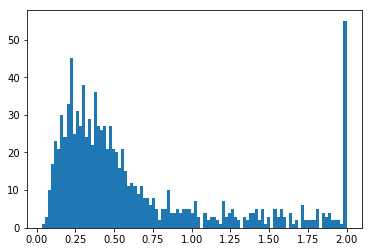

In [52]:
%pylab inline
plt.hist(lst,bins=100);
print np.mean(lst) 

0.713198 0.932576 0.412633


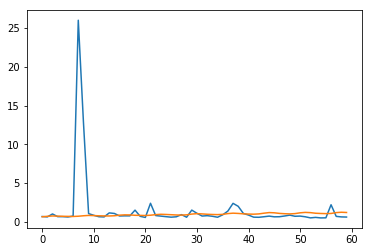

In [53]:
i=int(np.random.random()*1000)
u=Y[i][:60]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

In [54]:
daily_data.shape,attrib_data.shape

((145063, 550), (145063, 12))

In [71]:
X1=daily_data[:,-128:]
mad=np.median(X1[:,-60:],1) 
mad[mad==0]=1.0
X1=np.concatenate([X1/mad.reshape(-1,1),mad.reshape(-1,1)],axis=1)
attrib_test=attrib_data
X1.shape,attrib_test.shape

((145063, 129), (145063, 12))

In [72]:
feed_dict={x:X1,x2:attrib_test}
predTest=sess.run(prediction,feed_dict=feed_dict)
predTest.shape

(145063, 60)

In [73]:
mad.shape

(145063,)

In [74]:
predTest=predTest*mad.reshape(-1,1)

In [75]:
predTest=np.round(predTest,1)
np.mean(predTest<0.001)

1.1948831427264936e-05

In [76]:
cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 1, 1)), periods=60).map(lambda u: u.strftime("%Y-%m-%d"))
idx=pd.read_csv("../input/train_1.csv",usecols=[0])["Page"]
idx.shape

(145063,)

In [77]:
submission=pd.DataFrame(predTest,columns=cols,index=idx)
submission=submission.unstack().reset_index()
submission['name']=submission.apply(lambda r: r['Page']+"_"+r['level_0'],axis=1)
submission=submission.drop(['Page','level_0'],axis=1)
submission.columns=['Visits','name']

In [78]:
submission=submission[["name",'Visits']]
submission.head()

name     Visits
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  19.200001
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  21.400000
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.600000
3  4minute_zh.wikipedia.org_all-access_spider_201...  14.000000
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.300000

In [79]:
keys=pd.read_csv("../input/key_1.csv",index_col=0)

In [80]:
keys_dict=keys["Id"].to_dict()

In [81]:
submission["Id"]=submission["name"].apply(lambda u:keys_dict[u])

In [82]:
submission.isnull().sum().sum()

0L

In [83]:
submission.head()

name     Visits            Id
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  19.200001  ff8c1aade3de
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  21.400000  3da6fd5b23c1
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.600000  cd9e83803be4
3  4minute_zh.wikipedia.org_all-access_spider_201...  14.000000  65cd4af0968c
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.300000  75bae1fb2637

In [84]:
submission[["Id","Visits"]].to_csv("../submission/sub_pred_lstm1_60_medadj60_nozero_noxpad.csv.gz",
                                   index=None, float_format='%.1f', compression="gzip")